## Prediction Using 2-layer Feed forward network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [3]:
force1=pd.read_csv('FlowStress_Prediction.csv')

In [4]:
force1['strain']=np.log(force1['sch_entry_thickness']/force1['sch_exit_thickness'])
force1['strain_rate']=force1['strain']*force1['meas_speed_fpm']/np.sqrt(0.5*force1['avgrolldiam']*(force1['sch_entry_thickness']-force1['sch_exit_thickness']))
force1['ln_strain']=np.log(force1['strain'])
force1['ln_strain_rate']=np.log(force1['strain_rate'])
force1['core_temp']=force1['meas_entry_temp']+5/9*0.75*force1['model_target_gauge']*(force1['meas_entry_temp']**4/308300000000+(force1['meas_entry_temp']-70)**1.25/1412)
R=8.314
force1['1/RT']=1/(R*force1['core_temp'])

In [5]:
a=force1.loc[force1['model_grade']=='01010095FH1 ']

In [6]:
a = a.dropna(subset=['1/RT'])

In [7]:
RT= a['1/RT']
strain_rate = a['strain_rate']
measured_values = a['meas_flow_stress']
temp=a['core_temp']

In [8]:
input_features = a[['1/RT','strain','strain_rate','meas_flow_stress']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(a[['1/RT','strain','strain_rate','meas_flow_stress']])


In [9]:
# Convert to PyTorch tensor
x_train = torch.tensor(scaled_data, dtype=torch.float32)

In [10]:
# Define the neural network model
class ZenerHollomonModel(nn.Module):
    def __init__(self):
        super(ZenerHollomonModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # First layer: 4 input features, 64 hidden units
        self.fc2 = nn.Linear(64, 4)   # Second layer: 64 hidden units, 4 output units 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the output of the first layer
        x = self.fc2(x)              # Output layer, no activation function for coefficients
        return x

In [11]:
# Define the loss function and optimizer
model = ZenerHollomonModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
num_epochs = 2500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    
    # Assuming you have the ground truth coefficients from another source
    # For demonstration, randomly generate target coefficients
    target_coefficients = torch.tensor(a['meas_flow_stress'].values).float().view(-1, 1)
    
    loss = criterion(outputs, target_coefficients)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\SDEY\AppData\Local\anaconda3\envs\pyt-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([164, 1])) that is different to the input size (torch.Size([164, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/2500], Loss: 32.5658
Epoch [200/2500], Loss: 1.6506
Epoch [300/2500], Loss: 1.2933
Epoch [400/2500], Loss: 1.1369
Epoch [500/2500], Loss: 0.9309
Epoch [600/2500], Loss: 0.7285
Epoch [700/2500], Loss: 0.5472
Epoch [800/2500], Loss: 0.3952
Epoch [900/2500], Loss: 0.2752
Epoch [1000/2500], Loss: 0.1846
Epoch [1100/2500], Loss: 0.1189
Epoch [1200/2500], Loss: 0.0732
Epoch [1300/2500], Loss: 0.0426
Epoch [1400/2500], Loss: 0.0235
Epoch [1500/2500], Loss: 0.0125
Epoch [1600/2500], Loss: 0.0066
Epoch [1700/2500], Loss: 0.0037
Epoch [1800/2500], Loss: 0.0023
Epoch [1900/2500], Loss: 0.0016
Epoch [2000/2500], Loss: 0.0013
Epoch [2100/2500], Loss: 0.0011
Epoch [2200/2500], Loss: 0.0010
Epoch [2300/2500], Loss: 0.0010
Epoch [2400/2500], Loss: 0.0009
Epoch [2500/2500], Loss: 0.0008


In [13]:
# Use the model for prediction
with torch.no_grad():
    predicted_coefficients = model(x_train)
    #print("Predicted coefficients:", predicted_coefficients)

# Denormalize the predictions
predicted_values = scaler.inverse_transform(predicted_coefficients)
print(predicted_values)

[[1.59911060e-04 3.71827849e-01 3.07816634e+01 2.58998355e+01]
 [2.62167863e-04 7.58795385e-01 5.94572715e+01 4.99100380e+01]
 [3.55391440e-04 1.11186059e+00 8.56747820e+01 7.21273115e+01]
 [3.80110176e-04 1.20491904e+00 9.26038512e+01 7.79383050e+01]
 [3.91594552e-04 1.24901988e+00 9.58514381e+01 8.08667943e+01]
 [4.04857856e-04 1.29662786e+00 9.95134873e+01 8.37903021e+01]
 [4.20663144e-04 1.35760443e+00 1.03971833e+02 8.76878746e+01]
 [4.42862435e-04 1.43328653e+00 1.10057038e+02 9.25690585e+01]
 [4.63130705e-04 1.50980928e+00 1.15739502e+02 9.74488178e+01]
 [5.06807498e-04 1.65978330e+00 1.27748190e+02 1.07193138e+02]
 [3.47910902e-04 1.06686337e+00 8.34297021e+01 7.00642012e+01]
 [3.86306872e-04 1.22458401e+00 9.41985006e+01 7.92709524e+01]
 [1.87424382e-04 4.76923588e-01 3.84998617e+01 3.25390459e+01]
 [3.11010485e-04 9.43898285e-01 7.31924093e+01 6.14876545e+01]
 [3.83839481e-04 1.21955044e+00 9.36745909e+01 7.88820647e+01]
 [4.00906132e-04 1.28318286e+00 9.84336994e+01 8.275881

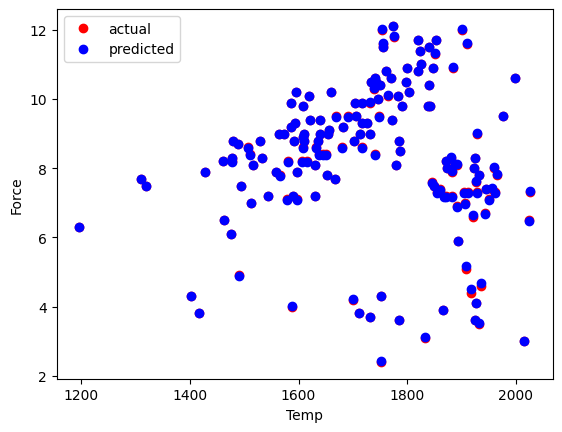

In [14]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],predicted_coefficients[:,3],'bo',label='predicted')
plt.xlabel('Temp')
plt.ylabel('Force')
plt.legend()
plt.show()

## Loss : 0.0008

As can be seen from the plot above, the prediction is pretty good.
- It can be made better by increasing the number of epochs.
- The training currently is on the entire dataset, it would be worthwhile to split it into training and test data and recheck the loss.